In [2]:
# Import packages
import os

import bayes_net_utils as bn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import boxcox

import seaborn as sns

sns.set(style="ticks", color_codes=True)
%matplotlib inline

# Introduction

Notebook for generating three kinds of dataset:

1) Observed seasonally-aggregated data, just for the variables that are predicted by the Bayesian network, for use when calculating goodness-of-fit statistics of predictions

2) A training data set for the GBN, for use in notebook Fit_BN. If met data is included as an explanatory variable, then the training data will include met variables. Compared to the observations csv, the training data is truncated to 1981 onwards and the cyanobacteria observations are box cox transformed (this was done within this notebook rather than within the R notebook where the GBN is fit, just because I am more familiar with Python than R).

3) An evidence dataset for the historic period, to be used for driving historic GBN predictions (hindcasts). Derived from the training data by filling NaNs and only including columns which would be used in generating an operational seasonal forecast. Filling NaNs: there are more sophisticated ways this could be done (e.g. using the "impute" function in bnlearn?), but for now start off by just linearly interpolating or backwards filling missing values, exactly as I did to generate data matrices for use in cross validation of the network.

This processing starts again with the raw daily data, as in the first notebook, and therefore repeats a lot of the processing. This was to provide a cleaner workflow that just uses the variables of interest, for future updating of the GBN as new data become available.

# User input

Paths to files and folders, and some other settings

In [11]:
# PATHS TO FILES AND FOLDERS

# Define start and end years
start_year_obs = 1980  # This only applies for the csv of observations
start_year = 1981  # For training and evidence data

# Start and end years for training and evidence data
end_yr_dict = {
    "metno": 2018,
    "era5": 2018,    # data to 2019 available
    "nomet": 2020,   # WQ data to 2020 are available
    }

# Include met data in the observations, training data and evidence data?
# If so, use era5 data or met.no data? Metno data used for GBN development reported in Jackson-Blake et al., HESS (2022)
met_source = "metno"  # Choose from 'metno', 'era5', 'nomet'

if met_source != "nomet":
    # Met (precipitation, wind)
    met_fpath_dict = {
        "metno": r"../../Data/Meteorological/Obs_metno/Obs_Metno_1km_gridded_Morsa_v2.csv",
        "era5": r"../../Data/Meteorological/06_era5/era5_morsa_1980-2019_daily.csv",
    }

    if met_source == "metno":
        # Wind is in a separate file
        # Mean daily wind speed (m/s), Rygge airport
        wind_fpath = r"../../Data/Meteorological/Obs_metno/Obs_Rygge_MeanWindSpeed.csv"

# Lake water quality
lakewq_fpath = r"../../Data/Observed_Chem_Ecol/Van2_Vanemfjorden_chem_obs.csv"

# Alternative lake colour data (from Storefjorden, 20m depth, MOVAR data)
movar_color_fpath = r"../../Data/Observed_Chem_Ecol/LakeColour_MOVAR.csv"

# Cyanobacteria data
ecol_fpath = r"../../Data/Observed_Chem_Ecol/Van2_Vanemfjorden_Cyanobacteria.csv"

# LOCATION OF OUTPUT FOLDERS AND FILENAMES
end_year = end_yr_dict[met_source]

# Observations
out_file_obs = r"../Data/DataMatrices/Seasonal_BN_obs/seasonal_obs_GBN_%s-%s.csv" % (
    start_year_obs, end_year)

# Training data
out_file_training = r"../Data/BN_TrainingData/TrainingData_GaussianBN_%s_%s-%s.csv" % (
    met_source, start_year, end_year)

# Evidence data for prediction
out_fold_evidence = r"../Data/DataForPrediction/Historic/%s" % met_source
out_fname_evidence = "DataForPrediction_GBN_%s_%s-%s.csv" % (
    met_source, start_year, end_year)

# Figures
tseries_plot_folder = r"../Figures"
daily_fig_path = os.path.join(
    tseries_plot_folder, "TrainingData_daily_%s_1981-%s.png" % (met_source, end_year)
)
sixM_tseries_path = os.path.join(
    tseries_plot_folder,
    "TrainingData_GBN_%s_1981-%s_blackwhite.png" % (met_source, end_year),
)

# Read in daily data

In [4]:
if met_source != "nomet":
    # Read in met data
    met_fpath = met_fpath_dict[met_source]

    if met_source == "metno":
        met_df = pd.read_csv(met_fpath, index_col=0, parse_dates=True, dayfirst=True)
        wind_df = pd.read_csv(wind_fpath, index_col=0, parse_dates=True, dayfirst=True)
        # Use rainfall averaged over whole catchment, not just the lake
        met_df = met_df[["RR_catch"]]
        met_df.columns = ["rain"]
        met_df.index.name = "Date"
        met_df.index = met_df.index.normalize()  # Drop time info from metdf index
        # Add mean daily wind speed (m/s)
        met_df["wind_speed"] = wind_df.iloc[:, 0]

    else:
        met_df = bn.read_era5_csv(met_fpath)  # Read in, calculate wind and reformat

    # Reset any negative values to 0
    met_df.loc[met_df["rain"] < 0.0, "rain"] = 0.0

met_df.head()

,rain,wind_speed
Date,,
1970-12-31,0.000000,4.6
1971-01-01,0.000000,0.2
1971-01-02,0.000000,0.3
1971-01-03,0.000000,6.0
1971-01-04,0.000096,2.2


In [5]:
# Lake chem data and chl-a

# Routine monitoring data
lakewq_df = pd.read_csv(lakewq_fpath, index_col=0, parse_dates=True, dayfirst=True)

# Movar colour data for historic period
color_df = pd.read_csv(movar_color_fpath, index_col=0, parse_dates=True, dayfirst=True)

# Process Lake colour data: merge MOVAR and NIVA data.
# Before Jan 1999: NIVA data. Jan 1999- end 2012: Movar data. From Jan 2013: NIVA data

lakewq_df = pd.merge(lakewq_df, color_df, left_index=True, right_index=True, how="outer")

lakewq_df.rename(
    {"colour": "colour_NIVA", "Colour": "colour_Movar"}, inplace=True, axis=1
)

# Before Jan 1999: NIVA data, Jan 1999- end 2012: Movar data, from Jan 2013: NIVA data
s0 = lakewq_df.loc[:"1998-12-31", "colour_NIVA"]
id1 = lakewq_df["colour_Movar"].first_valid_index()
s1 = lakewq_df["colour_Movar"].loc[id1:]
lastidx = lakewq_df.loc["2013-01-01":, "colour_NIVA"].last_valid_index()
s2 = lakewq_df.loc["2013-01-01":lastidx, "colour_NIVA"]
colour = pd.concat([s0, s1, s2], axis=0).dropna()
colour.name = "colour"

# Drop original MOVAR and NIVA colour series, and replace with the patched series
lakewq_df = lakewq_df.drop(["colour_NIVA", "colour_Movar"], axis=1)
lakewq_df = lakewq_df.merge(
    colour.to_frame(), left_index=True, right_index=True, how="outer"
)

# Drop some dodgy-looking values
lakewq_df.loc[:"1982-08-01", "colour"] = np.NaN

lakewq_df.tail()

,chl-a,TP,colour
Date,,,
2020-08-10,28.0,20.0,52.0
2020-08-24,13.0,28.0,NaN
2020-09-07,13.0,17.0,47.0
2020-09-21,7.9,17.0,NaN
2020-10-05,6.0,44.0,43.0


In [6]:
# Ecol count data

ecol_df = pd.read_csv(ecol_fpath, index_col=0, parse_dates=True, dayfirst=True)
# convert units to mm3/l (mg/l if assume density is same as water)
ecol_df['Cyano_biovol_mm3_per_l'] = ecol_df['Cyano_biovol_mm3_per_m3']/1000.
ecol_df.drop(['Cyano_biovol_mm3_per_m3'], axis=1, inplace=True)
ecol_df.head()

,Cyano_biovol_mm3_per_l
Date,
1996-06-13,0.12
1996-07-01,1.83
1996-07-22,4.42
1996-08-12,4.23
1996-09-03,4.80


# Merge and visualise daily data

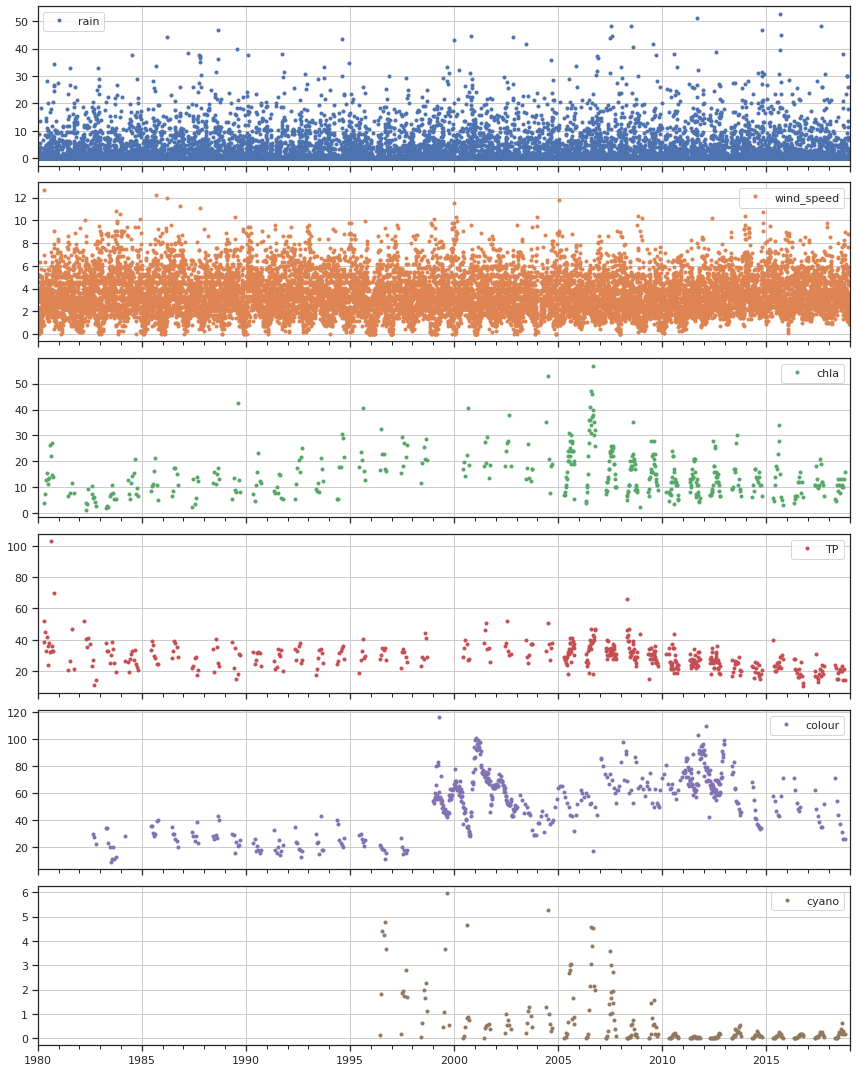

In [13]:
# REINDEX & JOIN ALL DATASETS INTO ONE DATAFRAME

if met_source != 'nomet':
    df_list = [met_df, lakewq_df, ecol_df]
else:
    df_list = [lakewq_df, ecol_df]

for i, df in enumerate(df_list):
    df = df.reindex(index=pd.date_range(start='01/01/%s' % start_year_obs,
                                        end='%s/12/31' % end_year))
    if i < 1:
        daily_df = df
    else:
        daily_df = daily_df.join(df)

# Remove data pre-1980
daily_df = daily_df.loc['1980-01-01':, :]

# Rename some cols
var_rename_dict = {'Biovolume_mm3_per_l': 'Biovolume',
                   'Cyano_biovol_mm3_per_l': 'cyano',
                   'chl-a': 'chla'}
daily_df.rename(var_rename_dict, axis=1, inplace=True)

cols_to_keep = ['TP', 'chla', 'colour', 'cyano',
                'rain', 'wind_speed']

for col in daily_df.columns:
    if col not in cols_to_keep:
        daily_df.drop(col, axis=1, inplace=True)

# Check output
daily_df.head()

daily_fig = daily_df.loc['1980-01-01':, :].plot(subplots=True, style='o', ms=3,
                                                figsize=(12, 15), grid=True);
plt.tight_layout()
plt.savefig(daily_fig_path)

# Resample to seasonal and add previous summer's values

Define two seasons per year. Lake sampling is from mid-April to mid-October, WFD status calculated as the average or maximum observed over the growing season, defined as May-Oct. So use WFD-based season definition of 'summer' vs 'winter'.

The main predictor variables are the values from the previous summer, so add these to the matrix.

In [14]:
summer_df = bn.daily_to_summer_season(daily_df)

# Add previous summer values for selected cols
prevSummerCols = summer_df[['colour', 'TP', 'chla']].shift(+1)
prevSummerCols = prevSummerCols.add_suffix('_prevSummer')
summer_df = summer_df.join(prevSummerCols)

# Truncate start and end years so covers period 1980/1-end year (incl.)
summer_df = summer_df.loc[start_year_obs:end_year, :]

summer_df.tail()

,rain,colour,TP,chla,wind_speed,cyano,colour_prevSummer,TP_prevSummer,chla_prevSummer
year,,,,,,,,,
2014,633.603979,41.863636,20.300000,12.600000,3.508840,0.283,60.223077,22.992308,14.138462
2015,684.936515,52.833333,24.250000,14.925000,3.769022,0.233,41.863636,20.300000,12.600000
2016,396.823713,52.000000,18.750000,9.590909,3.751630,0.166,52.833333,24.250000,14.925000
2017,570.221295,42.000000,19.666667,12.866667,3.705435,0.258,52.000000,18.750000,9.590909
2018,300.208553,36.333333,18.666667,10.741667,3.959783,0.614,42.000000,19.666667,12.866667


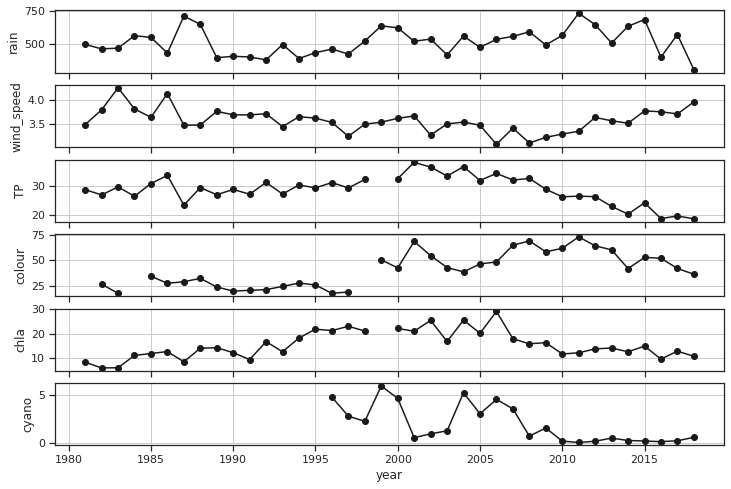

In [18]:
# Quick check of output
if met_source != 'nomet':
    vars_to_plot = ["rain", "wind_speed", "TP", "colour", "chla", "cyano"]
else:
    vars_to_plot = ["TP", "colour", "chla", "cyano"]
ax = summer_df[vars_to_plot].plot(
    subplots=True, figsize=(12, 8), grid=True, marker="o", legend=False, color='k'
)
for i in range(len(vars_to_plot)):
    ax[i].xaxis.grid(True, which="minor", linestyle="-", linewidth=0.5)
    ax[i].set_ylabel(vars_to_plot[i])

plt.savefig(sixM_tseries_path)

In [19]:
# Transform cyano data using boxcox transformation to make ~Gaussian
summer_df_bxcx = summer_df.copy()
for col in ['cyano']:
    summer_df_bxcx[col] = boxcox(summer_df_bxcx[col].values, lmbda=0.1)

In [20]:
# Write to csv

# Observations
summer_df[['TP', 'chla', 'colour', 'cyano']].to_csv(out_file_obs)

# Training data. First clip off 1980 if present
summer_df = summer_df.loc[1981:, :]
summer_df_bxcx.to_csv(out_file_training)

# Evidence data for making predictions

In [21]:
evidence_df = summer_df_bxcx.copy()

# Fill NaNs in water chemistry and ecology (linearly interpolate and backwards fill)
evidence_df.interpolate(method='linear', limit=1, inplace=True)
for col in ['colour_prevSummer']:
    evidence_df[col] = evidence_df[col].fillna(method='bfill', limit=2)

# Just select measurable/predictable columns that will be used when generating forecast
evidence_df = evidence_df.drop(['TP', 'colour', 'chla', 'cyano'], axis=1)
evidence_df = evidence_df.loc[1981:]

# Save to csv
out_fpath_evidence = os.path.join(out_fold_evidence, out_fname_evidence)
evidence_df.to_csv(out_fpath_evidence)

evidence_df.tail()

,rain,wind_speed,colour_prevSummer,TP_prevSummer,chla_prevSummer
year,,,,,
2014,633.603979,3.508840,60.223077,22.992308,14.138462
2015,684.936515,3.769022,41.863636,20.300000,12.600000
2016,396.823713,3.751630,52.833333,24.250000,14.925000
2017,570.221295,3.705435,52.000000,18.750000,9.590909
2018,300.208553,3.959783,42.000000,19.666667,12.866667
